<a href="https://colab.research.google.com/github/maheshr24/Paddy-Cultivation/blob/main/Paddy%20disease%20classifier%20using%20MobileNet%20(Quality%20assurance).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
df=pd.read_csv('/content/train (2).csv')
df.head(5)

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [ ]:
labels = ['blast', 'blight', 'brown_spot', 'dead_heart', 'downy', 'hispa', 'normal', 'panicle_blight', 'streak', 'tungro']
img_size = 400

train_dataset = image_dataset_from_directory(
    '/content/train',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=True,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.1,
    subset='training',
    seed=22
)
val_dataset = image_dataset_from_directory(
    '/content/train',
    image_size = (img_size,img_size),
    batch_size = 64,
    shuffle=False,
    labels='inferred',
    class_names = labels,
    label_mode = 'categorical',
    color_mode='rgb',
    validation_split = 0.1,
    subset='validation',
    seed=22
)

Found 3255 files belonging to 10 classes.
Using 2930 files for training.
Found 3255 files belonging to 10 classes.
Using 325 files for validation.


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
def get_model(base, preprocessor, img_size):
    inputs = tf.keras.Input(shape=(img_size,img_size,3))
    x = RandomFlip('horizontal')(inputs)
    x = preprocessor(x)
    x = base(x)

    x = tfl.Flatten()(x)
    x = tfl.Dense(1024, activation='relu')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(512, activation='relu')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(128, activation='relu')(x)
    x = tfl.Dropout(0.15)(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.Dense(64, activation='relu')(x)
    x = tfl.Dropout(0.3)(x)
    x = tfl.BatchNormalization()(x)
    outputs = tfl.Dense(10, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    return model

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=(img_size,img_size,3),
                                         include_top=False,
                                         weights='imagenet')

pre_trained_model.trainable = False

In [ ]:
model = get_model(pre_trained_model, preprocess_input, img_size)

model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5,
                    verbose=1)


Epoch 1/5
46/46 [==============================] - 709s 15s/step - loss: 0.2400 - accuracy: 0.9300 - val_loss: 0.8569 - val_accuracy: 0.5815
Epoch 2/5
46/46 [==============================] - 678s 15s/step - loss: 0.1929 - accuracy: 0.9440 - val_loss: 0.8155 - val_accuracy: 0.6154
Epoch 3/5
46/46 [==============================] - 665s 14s/step - loss: 0.1631 - accuracy: 0.9491 - val_loss: 0.6013 - val_accuracy: 0.6800
Epoch 4/5
46/46 [==============================] - 619s 13s/step - loss: 0.1379 - accuracy: 0.9549 - val_loss: 0.6514 - val_accuracy: 0.6462
Epoch 5/5
46/46 [==============================] - 674s 15s/step - loss: 0.1366 - accuracy: 0.9526 - val_loss: 0.5526 - val_accuracy: 0.6923


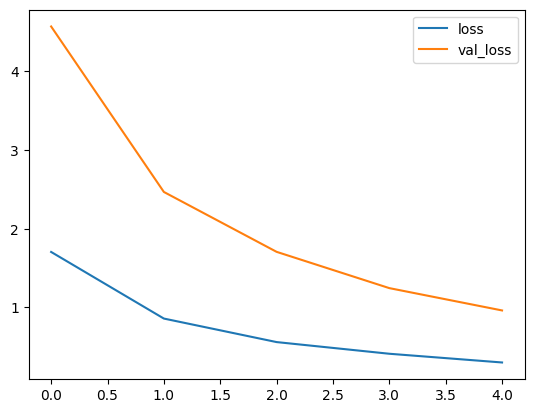

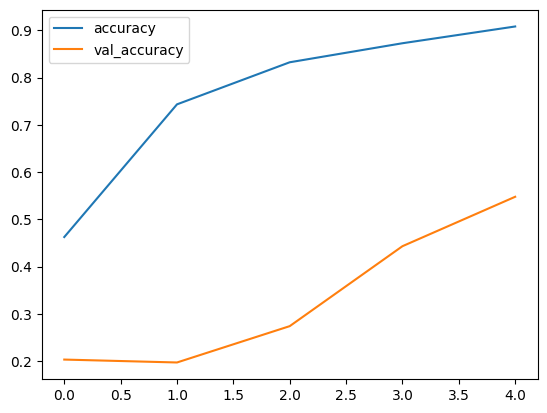

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [ ]:
print('Number of layers in the MobileNetV2 Model : ', len(pre_trained_model.layers))


# Here I am training the layers from 120th layer onwards.
for layer in pre_trained_model.layers[120:]:
    layer.trainable=True

Number of layers in the MobileNetV2 Model :  154


In [ ]:
model_tuned = get_model(pre_trained_model, preprocess_input, img_size)

model_tuned.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_tuned = model_tuned.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5,
                    verbose=1)

Epoch 1/14
46/46 [==============================] - 747s 16s/step - loss: 1.6922 - accuracy: 0.4608 - val_loss: 6.2473 - val_accuracy: 0.0092
Epoch 2/14
46/46 [==============================] - 731s 16s/step - loss: 0.8647 - accuracy: 0.7481 - val_loss: 2.3857 - val_accuracy: 0.0154
Epoch 3/14
46/46 [==============================] - 719s 16s/step - loss: 0.5502 - accuracy: 0.8481 - val_loss: 2.3096 - val_accuracy: 0.0400
Epoch 4/14
46/46 [==============================] - 718s 16s/step - loss: 0.3693 - accuracy: 0.9000 - val_loss: 2.3291 - val_accuracy: 0.0492
Epoch 5/14
46/46 [==============================] - 725s 16s/step - loss: 0.2749 - accuracy: 0.9242 - val_loss: 2.3704 - val_accuracy: 0.0985
Epoch 6/14
46/46 [==============================] - 712s 15s/step - loss: 0.2132 - accuracy: 0.9427 - val_loss: 2.3709 - val_accuracy: 0.1077
Epoch 7/14
46/46 [==============================] - 716s 16s/step - loss: 0.1652 - accuracy: 0.9495 - val_loss: 2.3422 - val_accuracy: 0.0954
Epoch 

In [ ]:
history_df = pd.DataFrame(history_tuned.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()